In [23]:
import requests
import time
import json

class APIwrapper:
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last API access

    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        self.count=None

    def get_page(self, filters={}, page_size=5):
        if page_size > 365:
            raise ValueError("Max supported page size is 365")
        if filters != self._filters or page_size != self._page_size:
            self._filters = filters
            self._page_size = page_size
            self._next_url = self._start_url
        if self._next_url is None:
            return []
        curr_time = time.time()
        deltat = curr_time - APIwrapper._last_access
        if deltat < 0.33:
            time.sleep(0.33 - deltat)
        APIwrapper._last_access = curr_time
        parameters = {x: y for x, y in filters.items() if y is not None}
        parameters['page_size'] = page_size
        response = requests.get(self._next_url, params=parameters).json()
        self._next_url = response.get('next')
        self.count = response['count']
        return response['results']

# Common structure for both queries
structure = {
    "theme": "infectious_disease",
    "sub_theme": "respiratory",
    "topic": "RSV",
    "geography_type": "Nation",
    "geography": "England"
}

# Filters for the year 2024
filters = {
    "stratum": None,
    "age": None,
    "sex": None,
    "year": 2024,
    "month": None,
    "epiweek": None,
    "date": None,
    "in_reporting_delay_period": None
}

# Retrieving data for RSV healthcare admission rate by week
structure["metric"] = "RSV_healthcare_admissionRateByWeek"
api_admissions = APIwrapper(**structure)
admissions = []
page = 1
while True:
    data = api_admissions.get_page(filters, page_size=365)
    print(f"Pages retrieved (admissions): {page}")
    if data == []:
        break
    admissions.extend(data)
    page += 1
print(f"Data points expected (admissions): {api_admissions.count}")
print(f"Data points retrieved (admissions): {len(admissions)}")

# Retrieving data for RSV testing positivity by week
structure["metric"] = "RSV_testing_positivityByWeek"
api_positivity = APIwrapper(**structure)
positivity = []
page = 1
while True:
    data = api_positivity.get_page(filters, page_size=365)
    print(f"Pages retrieved (positivity): {page}")
    if data == []:
        break
    positivity.extend(data)
    page += 1
print(f"Data points expected (positivity): {api_positivity.count}")
print(f"Data points retrieved (positivity): {len(positivity)}")

# Save the admissions data to admissions_attempt2.json
with open("admissions_attempt2.json", "wt") as OUTF:
    json.dump(admissions, OUTF)

# Save the positivity data to positivity_attempt2.json
with open("positivity_attempt2.json", "wt") as OUTF:
    json.dump(positivity, OUTF)



Pages retrieved (admissions): 1
Pages retrieved (admissions): 2
Pages retrieved (admissions): 3
Data points expected (admissions): 430
Data points retrieved (admissions): 430
Pages retrieved (positivity): 1
Pages retrieved (positivity): 2
Data points expected (positivity): 345
Data points retrieved (positivity): 345


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [26]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [27]:
with open("admissions_attempt2.json", "rt") as INFILE:
    admissions=json.load(INFILE)
with open("positivity_attempt2.json", "rt") as INFILE:
    positivity=json.load(INFILE)

In [28]:
data={}
for dataset in [admissions, positivity]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value

In [29]:
dates=list(data.keys())
dates.sort()
dates 

['2024-01-01',
 '2024-01-08',
 '2024-01-15',
 '2024-01-22',
 '2024-01-29',
 '2024-02-05',
 '2024-02-12',
 '2024-02-19',
 '2024-02-26',
 '2024-03-04',
 '2024-03-11',
 '2024-03-18',
 '2024-03-25',
 '2024-04-01',
 '2024-04-08',
 '2024-04-15',
 '2024-04-22',
 '2024-04-29',
 '2024-05-06',
 '2024-05-13',
 '2024-05-20',
 '2024-05-27',
 '2024-06-03',
 '2024-06-10',
 '2024-06-17',
 '2024-06-24',
 '2024-07-01',
 '2024-07-08',
 '2024-07-15',
 '2024-07-22',
 '2024-07-29',
 '2024-08-05',
 '2024-08-12',
 '2024-08-19',
 '2024-08-26',
 '2024-09-02',
 '2024-09-09',
 '2024-09-16',
 '2024-09-23',
 '2024-09-30',
 '2024-10-07']

In [30]:
data['2024-01-01']

{'RSV_healthcare_admissionRateByWeek': 0.13,
 'RSV_testing_positivityByWeek': 4.5}

In [31]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [32]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print(f"Data range: {startdate} to {enddate}")

Data range: 2024-01-01 00:00:00 to 2024-10-07 00:00:00


In [33]:
index=pd.date_range(startdate, enddate, freq='W-MON')
timeseriesdf=pd.DataFrame(index=index, columns=[ 'admissions', 'positivity'])
timeseriesdf

,admissions,positivity
2024-01-01,NaN,NaN
2024-01-08,NaN,NaN
2024-01-15,NaN,NaN
2024-01-22,NaN,NaN
2024-01-29,NaN,NaN
2024-02-05,NaN,NaN
2024-02-12,NaN,NaN
2024-02-19,NaN,NaN
2024-02-26,NaN,NaN
2024-03-04,NaN,NaN


In [34]:
# translate the columns to our metrics
metrics ={'admissions': 'RSV_healthcare_admissionRateByWeek',
          'positivity': 'RSV_testing_positivityByWeek'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['positivity', 'admissions']: 
        metric_name=metrics[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(metric_name, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
            
timeseriesdf

,admissions,positivity
2024-01-01,0.13,4.5
2024-01-08,3.95,3.13
2024-01-15,11.33,3.3
2024-01-22,0.07,2.88
2024-01-29,0.09,0.79
2024-02-05,0.26,1.17
2024-02-12,0.34,1.15
2024-02-19,0.19,0.78
2024-02-26,1.09,0.68
2024-03-04,0.54,0.88


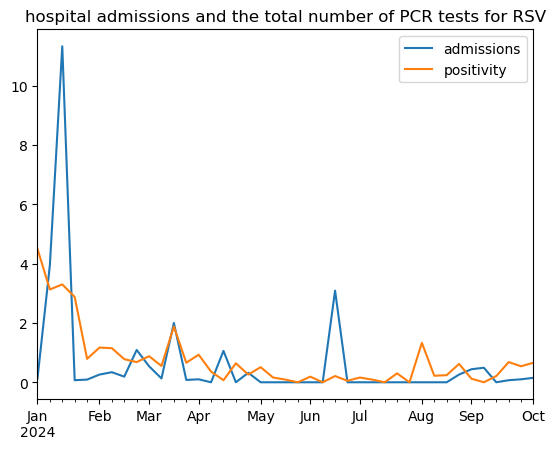

In [35]:
ax=timeseriesdf.plot() # easy peasy...
ax.set_title('hospital admissions and the total number of PCR tests for RSV');

Text(0.5, 1.0, 'hospital admissions and the total number of PCR tests for RSV (log scale)')

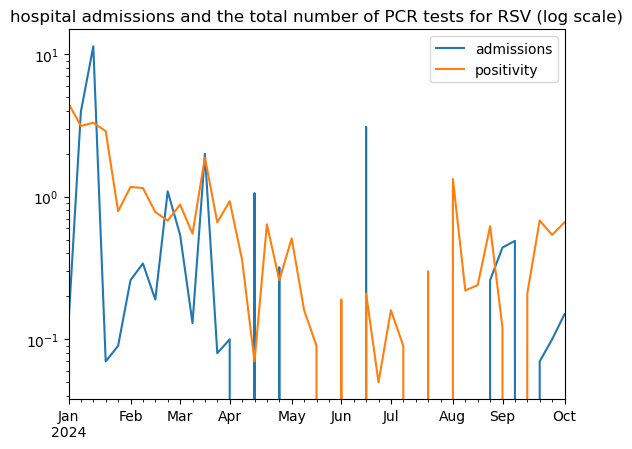

In [36]:
ax=timeseriesdf.plot(logy=True) # ...lemon squeezy
ax.set_title('hospital admissions and the total number of PCR tests for RSV (log scale)')

How to get yourself your data into a pickle (file)¶

In the actual dashboard, at this point, there is no need to save the dataframes - you can just add interactive controls to the graphs as you plot them. While developing, however, we want to save the wrangled data in order to be able to experiment with the controls. Pandas luckily makes it easy by providing a method that saves a DataFrame to a "pickle" file. This is based on the pickle library, that however is imported by pandas, so you do not need to import it yourself. While JSON is a standard format that is language-independent, a pickle file is Python-specific. This format is thus more flexible, allowing the serialisation of a broader range of Python objects; however, it is less portable.

In [38]:
# pandas makes saving to a pickle file dead easy:
timeseriesdf.to_pickle("timeseriesdf.pkl")

Adding interactive controls

We will be adding interactive controls to our graphs using the ipywidgets library. This is basically a Graphical User Interface (GUI) library that runs in a notebook. Its control elements (so-called widgets) are actually an interface to JavaScript code that runs in your browser (in a stardard GUI library meant for desktop applications, they would be written in some low-level language and interface with the window manager on your computer). An in-depth treatment of GUIs is beyond the scope of this tutorial. However, I will strive to highlight concepts of general applicability and to use a clean syntax that highlights where the various elements fit in and may be easier to port to other GUI toolkits. If you are interested in learning more about (desktop-based) GUIs in Python, I strongly recommend the appJar library - it is an excellent learning library and a great quick prototyping tool as well.

The ipywidgets library is an integral part of the Jupyter framework and should therefore already be installed on any machine you are running this notebook on. If for some reason it isn't, follow these instructions to install it.

In [39]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

Updating your data¶
It is a good idea to provide some data on the disk for your dashboard to start on - after all, the PHE website might be offline when someone accesses your dashboard; also, accessing the PHE website directly would make startup time longer. However, you can provide a button that the user can click to poll the API and refresh the data.

The ipywidgets library provides a Button class that implements a clickable button. The way this is linked to your code is through a callback function. This is a function that is passed as a parameter to the on_click method of the Button object, that in turn calls it when it is clicked. The callback function is passed the Button object itself as a parameter (which is useful if more than one button, for instance, shares the same callback). We can safely ignore that here.

The call to display below actually draws the button on the notebook.

In [41]:
# our API access function. This will be called by the button when it is clicked
def access_api(button):
    # Ignore the button parameter
    #
    # put code for polling the API here
    #
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again.
    apibutton.icon="check"
    apibutton.disabled=True

# see the doc for the parameters    
apibutton=wdg.Button(
    description='Refresh data',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to download current Public Health England data',
    icon='download' # (FontAwesome names without the `fa-` prefix)
)

# register the callback function with the button
apibutton.on_click(access_api)

# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets
display(apibutton)

Button(description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click to download current Pu…

Single-control graphs¶

Adding an interactive control to a graph is not much more complicated. The control can be any of the many widgets provided by iPywidgets. Here we have chosen Select that allows us to select a year (see the doc). We use the year to filter the DataFrame, and display the data for that year aggregated by month as a multiple stacked bar chart

Again, Select makes use of a callback, that gets passed the option that have been selected. Each time the selection is changed, the callback function is called again. The way the callback is registered with the widget is slightly different: the callback (here lineage_graph) must take a single parameter (the selected year, called graphyear). We then pass the callback to interactive_output, together with a dictionary that specifies which widget (year) must provide a value for the callback parameter (graphyear). Basically, the iPywidget framework calls lineage_graph with the value retrieved from the widget after each user interaction. The value of interactive_output is an Output widget (see the doc), that can be assigned to a variable and passed to display together with the year widget itself. Any printout, graph or other output of the callback lineage_graph is captured and displayed through that Output widget, that renders it in the browser.

In [42]:
# in the dashboard, this will be the dataframe that's computed directly from the json files,
# or from the current data downloaded from the API
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")

In [57]:
month=wdg.Select(
    # options available: unique years in the dataframe
    options=timeseriesdf.index.month.unique(), # options available
    value=timeseriesdf.index.month[-1], # initial value: most recent year
    rows=1, # rows of the selection box
    description='Month',
    disabled=False
)

def timeseries_graph(graphmonth):
    print(graphmonth)
    # our callback function.
    weekly=timeseriesdf[timeseriesdf.index.month==graphmonth]
    # average the rows by month
    # make sure it's all normalised to 100
    #weekly=weekly.div(totals, axis=0)*100
    # older dates on top of the graph
    weekly= weekly[::-1]
    ax=weekly.plot(kind='barh', stacked=True,cmap='tab20')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.set_yticklabels(weekly.index.strftime('%Y-%m-%d'))
    plt.show()
    
# keep calling age_graph(graphcolumns=value_of_agecols); capture output in widget output    
output=wdg.interactive_output(timeseries_graph, {'graphmonth': month})

display(month, output)

Select(description='Month', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), rows=1, value=10)

Output()

In [55]:
timeseriesdf.index.month.unique()

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int32')

Select(description='Year', options=(2024,), rows=1, value=2024)

Output()

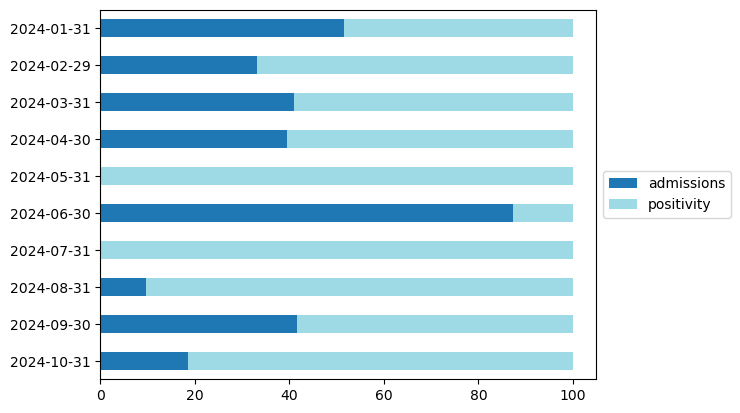

In [44]:
year=wdg.Select(
    # options available: unique years in the dataframe
    options=timeseriesdf.index.year.unique(), # options available
    value=timeseriesdf.index.year[-1], # initial value: most recent year
    rows=1, # rows of the selection box
    description='Year',
    disabled=False
)

def timeseries_graph(graphyear):
    # our callback function.
    yeardf=timeseriesdf[timeseriesdf.index.year==graphyear]
    # average the rows by month
    monthly= yeardf.groupby(pd.Grouper(freq='1M')).mean() 
    totals=monthly.sum(axis=1) # over the rows
    # make sure it's all normalised to 100
    monthly=monthly.div(totals, axis=0)*100
    # older dates on top of the graph
    monthly = monthly[::-1]
    ax=monthly.plot(kind='barh', stacked=True,cmap='tab20')
    ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.set_yticklabels(monthly.index.strftime('%Y-%m-%d'))
    
# keep calling age_graph(graphcolumns=value_of_agecols); capture output in widget output    
output=wdg.interactive_output(timeseries_graph, {'graphyear': year})

display(year, output)

Multiple-control graphs

In the time series graph, we may want to add a couple of controls - one for selecting the stats to display, and the other to choose between an linear and logarithmic scale. This second choice we can implement with a RadioButtons widget (documentation). This widget returns a Boolean value (True or False) to the callback function. The callback (in our case timeseries_graph) must then accept two parameteres, a tuple of stats coming from the SelectMultiple widget and the Boolean value from the RadioButtons. Again, the interactive_output function associates the widgets with the callback and captures the output in an Output widget.

The new element in this example is the container widget HBox. Container widgets are another feature shared by most GUI toolkits; they are used to group and arrange other widgets on the interface.

In [46]:
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")

In [47]:
series=wdg.SelectMultiple(
    options=[ 'admissions', 'positivity'],
    value=['admissions', 'positivity'],
    rows=3,
    description='Stats:',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
#   value='pineapple', # Defaults to 'pineapple'
#   layout={'width': 'max-content'}, # If the items' names are long
    description='Scale:',
    disabled=False
)

# try replacing HBox with a VBox
controls=wdg.HBox([series, scale])

def timeseries_graph(gcols, gscale):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        timeseriesdf[list(gcols)].plot(logy=logscale)
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# keep calling timeseries_graph(gcols=value_of_series, gscale=value_of_scale); 
# capture output in widget graph   
graph=wdg.interactive_output(timeseries_graph, {'gcols': series, 'gscale': scale})

display(controls, graph)

Output()